**Anomaly Detection**: 

The present project can be found by clicking the following link:

https://www.kaggle.com/competitions/anomaly-detection

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

#_______Scaling_______________
from sklearn.preprocessing import StandardScaler, RobustScaler

#___________Clasification________________
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#______Metric___________
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("anomaly_csv.csv")
df.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [3]:
(df
    .isnull()
    .sum() 
)

timestamp     0
value         0
is_anomaly    0
predicted     0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   15830 non-null  int64  
 1   value       15830 non-null  int64  
 2   is_anomaly  15830 non-null  bool   
 3   predicted   15830 non-null  float64
dtypes: bool(1), float64(1), int64(2)
memory usage: 386.6 KB


**We inicialize the timestamp to zero and set it as the index**

In [5]:
df.timestamp = df.timestamp-df.timestamp[0]
df= df.set_index("timestamp")

In [6]:
df.head()

,value,is_anomaly,predicted
timestamp,,,
0,42,False,44.072500
300,41,False,50.709390
600,41,False,81.405120
900,61,False,39.950367
1200,44,False,35.350160


In [7]:
(
    df
    .index
    .duplicated()
    .sum()
)

0

Counting the number of anomaly events

<Axes: >

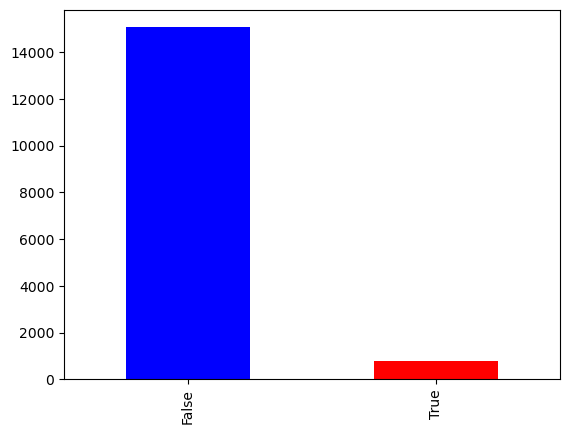

In [8]:
(
    df
    .is_anomaly
    .value_counts()   
    .plot(kind="bar", color=["blue","red"])
)

Turn the logic value *True*  and *False* into one and zero respectively.

In [9]:
mask = {True:1, False:0}
limit = int(0.2*len(df))
y = df.is_anomaly
X = df[['value', 'predicted']]
y = y.map(mask)

Scaling the data in order to accelerate the convergence during the training

In [10]:
#oe = StandardScaler()
oe = RobustScaler()
X_transformed = oe.fit_transform(X)


We use several clasification algorithms such as Logistic Regression, Support Vector Machine, Decision Tree and Random Forest in order to obtain the best performance. In this case, F1 score is considered instead of the precision and recall because of the trade-off between them. 

In [11]:
clf_LR = LogisticRegression()
clf_SVC = SVC()
clf_DT = DecisionTreeClassifier(criterion="entropy",max_depth=20)
clf_RF = RandomForestClassifier(criterion="entropy", max_depth=20)

object_AL = {"LR": clf_LR, 
             "SVM": clf_SVC,
             "DT": clf_DT,
             "RF": clf_RF
            }

metric_result = {}


For the training, we split the data using Time Series Cross-validation 

In [12]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def metric_algorithm(clf, X, y):
    f1  = []
             
    for train_index, test_index in tscv.split(X):

            X_train, X_test = X[:train_index[-1],:], X[:test_index[-1],:]
            y_train, y_test = y[:train_index[-1]], y[:test_index[-1]]
            
            print("Train:", train_index, "Test:", test_index)
            clf.fit(X_train,y_train)
            y_pred = clf.predict(X_test)
            f1.append(f1_score(y_test, y_pred))
    return np.mean(f1)
  


In [13]:
for key, value in object_AL.items():
    metric_result[key] = metric_algorithm(value, X_transformed, y) 
    
df_metric = pd.DataFrame(metric_result.items(), columns = ["AL","F1"] )    
df_metric.sort_values(by  = ["F1"],ascending = False)   

Train: [   0    1    2 ... 2637 2638 2639] Test: [2640 2641 2642 ... 5275 5276 5277]
Train: [   0    1    2 ... 5275 5276 5277] Test: [5278 5279 5280 ... 7913 7914 7915]
Train: [   0    1    2 ... 7913 7914 7915] Test: [ 7916  7917  7918 ... 10551 10552 10553]
Train: [    0     1     2 ... 10551 10552 10553] Test: [10554 10555 10556 ... 13189 13190 13191]
Train: [    0     1     2 ... 13189 13190 13191] Test: [13192 13193 13194 ... 15827 15828 15829]
Train: [   0    1    2 ... 2637 2638 2639] Test: [2640 2641 2642 ... 5275 5276 5277]
Train: [   0    1    2 ... 5275 5276 5277] Test: [5278 5279 5280 ... 7913 7914 7915]
Train: [   0    1    2 ... 7913 7914 7915] Test: [ 7916  7917  7918 ... 10551 10552 10553]
Train: [    0     1     2 ... 10551 10552 10553] Test: [10554 10555 10556 ... 13189 13190 13191]
Train: [    0     1     2 ... 13189 13190 13191] Test: [13192 13193 13194 ... 15827 15828 15829]
Train: [   0    1    2 ... 2637 2638 2639] Test: [2640 2641 2642 ... 5275 5276 5277]
Train

,AL,F1
3,RF,0.899459
2,DT,0.868825
1,SVM,0.500910
0,LR,0.486527


Based on F1 score we can conclude that Random Forest is the best choice.